(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [1]:
from vaderSentiment import make_lex_dict
from vaderSentiment import sentiment
import json
import string
import unicodedata

reviewsDict = {}

word_valence_dict = make_lex_dict('vader_sentiment_lexicon.txt')

def stripWords(text):
    text = "".join(x for x in text if x not in string.punctuation)
    try:
        text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    except TypeError:
        pass
    text = text.lower()
    words = text.split(' ')
    for word in words:
        if len(word) <= 1:
            words.remove(word)
    return words

def parseYelpReviews():
    file = open('yelp_academic_dataset_review.json', 'r')
    for line in file:
        jsonObject = json.loads(line)
        text = jsonObject['text']
        try:
            text = stripWords(text)
        except UnicodeEncodeError:
            text = None
        if text is not None:
            reviewsDict[jsonObject['review_id']] = [text, jsonObject['stars']]

parseYelpReviews()

sentimentValues = []

def makeSentiments(key):
    try:
        return sentiment(reviewsDict[key][0], word_valence_dict)
    except UnicodeEncodeError:
        return None

In [2]:
#takes ~2 hours to run the way it is, DO NOT RERUN THIS BLOCK
for key in reviewsDict.keys():
    value = makeSentiments(key)
    if value is not None:
        sentimentValues.append((value, reviewsDict[key][1]))

In [16]:
import pandas as pd
relations = {}
relations['sentiment'] = []
relations['stars'] = []
stars = {}
stars['1'] = []
stars['2'] = []
stars['3'] = []
stars['4'] = []
stars['5'] = []
for (x,y) in sentimentValues:
    relations['sentiment'].append(x)
    relations['stars'].append(y) 
    stars[str(y)].append(x) 
    
dataFrame = pd.DataFrame(relations)

In [11]:
print dataFrame

         sentiment  stars
0           0.9716      4
1          -0.5994      5
2          -0.9688      2
3           0.7845      4
4           0.8555      4
5           0.9745      4
6           0.9726      5
7           0.9001      5
8           0.8789      3
9           0.5690      1
10          0.9852      5
11          0.7611      4
12          0.7684      4
13          0.7814      5
14          0.1864      4
15          0.3277      2
16          0.9926      3
17          0.9240      4
18         -0.8095      1
19          0.4939      5
20          0.6249      3
21          0.4588      5
22          0.5664      1
23         -0.1036      4
24          0.8908      4
25         -0.3497      1
26          0.9856      4
27          0.6785      4
28         -0.3899      3
29          0.8750      5
...            ...    ...
2225183     0.9931      4
2225184     0.3649      2
2225185    -0.3455      4
2225186     0.9599      3
2225187     0.9970      3
2225188     0.8807      5
2225189     

In [12]:
print dataFrame.corr('pearson')

           sentiment     stars
sentiment   1.000000  0.580284
stars       0.580284  1.000000


Printed above is the score from the Vader Sentiment analyzer followed by the stars given by that review. The sentiment score is a compound based on a combination of 'negative', 'neutral' and 'positive' scores generated while parsing the file. All of the scores are normalized to be within the range -1 to 1, with 1 being extremely positive and -1 being extremely negative. Looking at some of the values it doesn't seem to be too accurate. A few to point out is the second one, where a 5 star rating got a score of -0.6 or the pair of (0.9654, 2). Excluding the occasional outlier, it seems to be accurate for the most part. 

I don't have an implemented way to go back to the text associated with the values only because it takes a long time to run this each time due to having to parse millions of sentences to do it and reading through them manually to see what went wrong would be very time consuming as well. 

Under all the values is the standard correlation coefficient determined by the pearson method implemented by pandas, stating a 0.58 correlation between our assigned sentiment value and the stars associated with them. 


#### Visualization and short (detailed) analysis. **(10 pts)**

In [113]:
# used for second histogram
scaleSentiments = []
for sentimentVal in dataFrame['sentiment']:
    if sentimentVal <= -0.6:
        scaleSentiments.append(-0.8)
    elif sentimentVal <= -0.2:
        scaleSentiments.append(-0.4)
    elif sentimentVal <= 0.2:
        scaleSentiments.append(0.0)
    elif sentimentVal <= 0.6:
        scaleSentiments.append(0.4)
    else:
        scaleSentiments.append(0.8)
scaleSentiments = np.array(scaleSentiments)

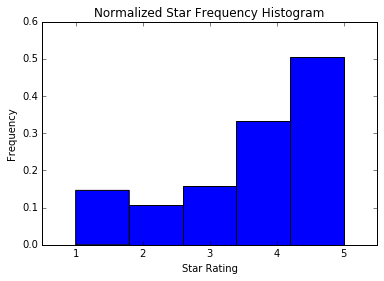

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(dataFrame['stars'], bins=5, align='mid', normed=True)
plt.axis([0.5,5.5,0,0.6])
plt.xticks(np.arange(5)+1)
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Normalized Star Frequency Histogram')
plt.show()

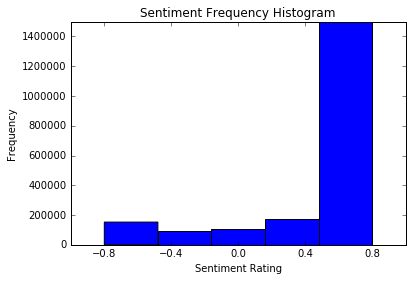

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(scaleSentiments, bins=5, align='mid')
plt.axis([-1,1,0,1500000])
plt.xticks([-0.8, -0.4, 0, 0.4, 0.8])
plt.xlabel('Sentiment Rating')
plt.ylabel('Frequency')
plt.title('Sentiment Frequency Histogram')
plt.show()


The 2 histograms above show the frequency of stars and sentiments. The skew on the sentiment histogram explains why the algorithm had a 58% correlation, the Vader algorithm tended to think that most sentences expressed a positive seniment. As seen by the star histogram, about 50% were rated 5 stars, so by just guessing a high positive score approximately a 50% correlation could be achieved. The Vader algorithm scored about 8% better than just assuming higher sentiment values, which could either be poor negation detecting skills from the algorithm, unclear written reviews by the authors, or a combination of both. 

-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

In [2]:
import json
import numpy as np

file = open('yelp_academic_dataset_business.json', 'r')
jsonObjects = []
for line in file:
    jsonObject = json.loads(line)
    if jsonObject.get('city') == 'Las Vegas' and 'Restaurants' in jsonObject.get('categories'):
        jsonObjects.append( [[jsonObject.get('longitude'), jsonObject.get('latitude')], 
                           [set(jsonObject.get('categories')), jsonObject.get('attributes')]] )
        
allRestaurants = np.array(jsonObjects)

In [628]:
def getAllCategories(allRestaurants):
    string = ''
    
    for restaurant in allRestaurants:
        for x in restaurant[1][0]:
            string = string + ' ' + str(x)
    return [string]

In [696]:
# gets term frequency for all categories
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
allCategories = getAllCategories(allRestaurants)
categoryVectorizer = CountVectorizer()
X = categoryVectorizer.fit_transform(allCategories)

categoryTransformer = TfidfTransformer()
tfidf = categoryTransformer.fit_transform(X.toarray())

categoryFeatureIndex = categoryVectorizer.get_feature_names()
categoryTfidf = tfidf.toarray()

In [737]:
import sklearn.preprocessing as skpre
import sklearn.metrics as skmet
locations = []
for restaurant in allRestaurants:
    locations.append(restaurant[0])

In [702]:
import re
# defines similarity of categories by weights
def catSimilarity(setA, setB):
    regex = re.compile('[^a-zA-Z]')
    sumOf = 0
    total = 0
    for a in setA:
        modA = a
        modA = regex.sub(' ', modA)
        if ' ' in modA:
            modA = modA[:modA.index(' ')]
        modA = modA.lower()
        if a in setB:    
            sumOf = sumOf + categoryTfidf[0][categoryFeatureIndex.index(modA)]
        total = total + categoryTfidf[0][categoryFeatureIndex.index(modA)]
    return total - sumOf
            
categoriesSimilarity = [ [ catSimilarity(restaurant[1][0], restaurant2[1][0])  
                          for restaurant2 in allRestaurants] for restaurant in allRestaurants]

In [709]:
def getAllAttributes(allRestaurants):
    string = ''
    
    for restaurant in allRestaurants:
        for x in restaurant[1][1].keys():
            string = string + ' ' + str(x)
    return [string]

# gets term frequency for all attributes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
allAttributes = getAllAttributes(allRestaurants)
attributeVectorizer = CountVectorizer()
X2 = attributeVectorizer.fit_transform(allAttributes)

attributeTransformer = TfidfTransformer()
tfidf2 = attributeTransformer.fit_transform(X2.toarray())

attributeFeatureIndex = attributeVectorizer.get_feature_names()
attributeTfidf = tfidf2.toarray()

In [722]:
import re
# defines similarity of categories by weights
def attSimilarity(setA, setB):
    keysA = setA.keys()
    keysB = setB.keys()
    regex = re.compile('[^a-zA-Z]')
    sumOf = 0
    total = 0
    for a in keysA:
        modA = a
        modA = regex.sub(' ', modA)
        if ' ' in modA:
            modA = modA[:modA.index(' ')]
        if a in keysB and setA[a] == setB[a]:
            sumOf = sumOf + attributeTfidf[0][attributeFeatureIndex.index(modA.lower())]
        total = total + attributeTfidf[0][attributeFeatureIndex.index(modA.lower())]
    return total - sumOf
            
attributeSimilarity = [ [ attSimilarity(restaurant[1][1], restaurant2[1][1])  
                          for restaurant2 in allRestaurants] for restaurant in allRestaurants]

In [723]:
print attributeSimilarity[0]

[0.0, 0.98112512647873462, 1.8207909647150364, 0.83191370459353031, 1.3154616159304784, 1.1616880976979795, 0.41110319340095902, 1.5357456966998533, 1.5215448855135372, 1.3154616159304784, 1.3069891512855025, 2.6682775395467004, 2.5969647703284617, 1.3979223649447383, 0.95745710783487459, 0.87499635882061444, 1.3154616159304784, 1.4700926710703635, 1.0101441754246849, 1.52747904091265, 2.1603412785636884, 1.6673947627217875, 1.6753184037460362, 0.64277536430042304, 2.009449084340007, 3.0569818689267314, 1.0949031233507398, 1.5455559189203518, 1.6753184037460362, 1.5357456966998533, 1.684922817108762, 1.2883291481807781, 1.48813524760177, 2.2166300011645204, 1.0144318599616158, 2.0011824285528039, 1.3069891512855025, 1.8229519577216498, 1.0124423743364797, 1.0124423743364797, 1.3152558070727056, 1.1667990176660015, 0.87499635882061444, 1.1660100837112062, 1.7387075319400265, 0.85242598741820874, 1.6753184037460362, 1.9745644829475353, 0.86089845206318483, 1.6076758924914103, 1.592857654

In [724]:
# combine all similarity scores into one score matrix
score = skpre.normalize(categoriesSimilarity + attributesSimilarity)

In [725]:
print score

[[ 0.          0.01647561  0.01720427 ...,  0.00732411  0.01672784
   0.01286872]
 [ 0.01732399  0.          0.01070589 ...,  0.01647551  0.01006482
   0.01794987]
 [ 0.02016151  0.01117857  0.         ...,  0.02172376  0.01117857
   0.01569794]
 ..., 
 [ 0.0067731   0.01478438  0.01746432 ...,  0.          0.01287014
   0.00942451]
 [ 0.01903205  0.01013739  0.01089562 ...,  0.01528254  0.          0.01487635]
 [ 0.01330422  0.01795542  0.01418367 ...,  0.01022615  0.01381723  0.        ]]


Visualize your clusters using each technique. Label your clusters. **(10 pts)**

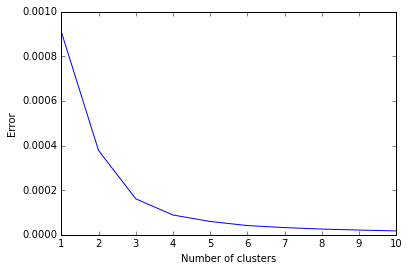

In [726]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

evaluate_clusters(locations,10)

In [802]:
kmeans = KMeans(init='k-means++', n_clusters=4)
kmeans_labels = kmeans.fit_predict(locations)

In [803]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

for i in range(0, len(kmeans_labels)):
    if kmeans_labels[i] == 0:
        cluster0.append(i)
    elif kmeans_labels[i] == 1:
        cluster1.append(i)
    elif kmeans_labels[i] == 2:
        cluster2.append(i)
    else:
        cluster3.append(i)
        
def makeScoreCluster(clusterVals):
    return [score[val] for val in clusterVals]
        

In [804]:
scoreCluster0 = makeScoreCluster(cluster0)
scoreCluster1 = makeScoreCluster(cluster1)
scoreCluster2 = makeScoreCluster(cluster2)
scoreCluster3 = makeScoreCluster(cluster3)

cluster0Kmeans = KMeans(init='k-means++', n_clusters=2)
cluster0Labels = cluster0Kmeans.fit_predict(scoreCluster0)

cluster1Kmeans = KMeans(init='k-means++', n_clusters=2)
cluster1Labels =cluster1Kmeans.fit_predict(scoreCluster1)

cluster2Kmeans = KMeans(init='k-means++', n_clusters=2)
cluster2Labels = cluster2Kmeans.fit_predict(scoreCluster2)

cluster3Kmeans = KMeans(init='k-means++', n_clusters=2)
cluster3Labels = cluster3Kmeans.fit_predict(scoreCluster3)

(-115.40000000000001, -114.95, 35.950000000000003, 36.350000000000001)

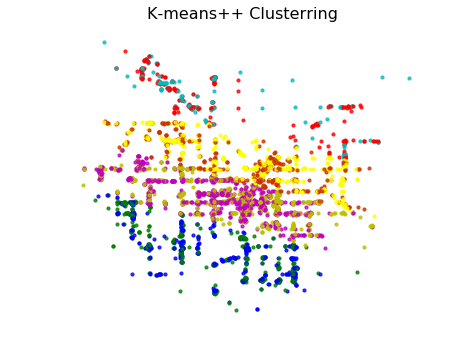

In [738]:
plt.figure(1, figsize=(16,12), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(221)
cluster0Colors = np.array([x for x in 'bg'])
cluster1Colors = np.array([x for x in 'rc'])
cluster2Colors = np.array([x for x in 'my'])
cluster3Colors = np.array(['#ffff00', '#cc3300']) 

j = 0
for i in cluster0:
    plt.scatter(locations[i][0], locations[i][1], color=cluster0Colors[cluster0Labels[j]], s=10, alpha=0.8)
    j = j + 1
    
j = 0
for i in cluster1:
    plt.scatter(locations[i][0], locations[i][1], color=cluster1Colors[cluster1Labels[j]], s=10, alpha=0.8)
    j = j + 1
    
j = 0
for i in cluster2:
    plt.scatter(locations[i][0], locations[i][1], color=cluster2Colors[cluster2Labels[j]], s=10, alpha=0.8)
    j = j + 1

j = 0
for i in cluster3:
    plt.scatter(locations[i][0], locations[i][1], color=cluster3Colors[cluster3Labels[j]], s=10, alpha=0.8)
    j = j + 1
    
plt.title('K-means++ Clusterring', fontsize=16)
plt.axis('off')

In [743]:
cluster0Restaurants = []
for i in cluster0:
    cluster0Restaurants.append(allRestaurants[i][1])
    
cluster1Restaurants = []
for i in cluster1:
    cluster1Restaurants.append(allRestaurants[i][1])

cluster2Restaurants = []
for i in cluster2:
    cluster2Restaurants.append(allRestaurants[i][1])
    
cluster3Restaurants = []
for i in cluster3:
    cluster3Restaurants.append(allRestaurants[i][1])

In [760]:
def label(clusterList):
    regex = re.compile('[^a-zA-Z]')
    cat = {}
    att = {}
    for (categ, attrib) in clusterList:
        for c in categ:
            c = str(c)
            if cat.get(c) is None:
                cat[c] = 1
            else:
                cat[c] = cat[c] + 1
        for a in attrib:
            a = str(a)
            if att.get(a) is None:
                att[a] = 1
            else:
                att[a] = att[a] + 1
                
    for c in cat:
        modC = c
        modC = regex.sub(' ', modC)
        if ' ' in modC:
            modC = modC[:modC.index(' ')]
        modC = modC.lower()
        cat[c] = cat[c] * categoryTfidf[0][categoryFeatureIndex.index(modC)]
        
    for a in att:
        modA = a
        modA = regex.sub(' ', modA)
        if ' ' in modA:
            modA = modA[:modA.index(' ')]
        modA = modA.lower()
        att[a] = att[a] * attributeTfidf[0][attributeFeatureIndex.index(modA)]
    return (cat, att)

In [776]:
import operator
(cat0, att0) = label(cluster0Restaurants)
(cat1, att1) = label(cluster1Restaurants)
(cat2, att2) = label(cluster2Restaurants)
(cat3, att3) = label(cluster3Restaurants)

def getTop2(cat, att):
    top2Cats = []
    for i in range(0,2):          
        keys = cat.keys()
        maxKey = keys[0]
        for key in keys:
            if cat[maxKey] < cat[key]:
                maxKey = key
        del cat[key]
        top2Cats.append(key)

    top2Atts = []
    for i in range(0,2):
        keys = att.keys()
        maxKey = keys[0]
        for key in keys:
            if att[maxKey] < att[key]:
                maxKey = key
        del att[key]
        top2Atts.append(key)
    return (top2Cats, top2Atts)

(top2Cats0, top2Atts0) = getTop2(cat0, att0)
(top2Cats1, top2Atts1) = getTop2(cat1, att1)
(top2Cats2, top2Atts2) = getTop2(cat2, att2)
(top2Cats3, top2Atts3) = getTop2(cat3, att3)

['Soul Food', 'Festivals'] ['Good For Groups', 'Has TV']


In [777]:
print (top2Cats0, top2Atts0)
print (top2Cats1, top2Atts1)
print (top2Cats2, top2Atts2)
print (top2Cats3, top2Atts3)

(['Soul Food', 'Festivals'], ['Good For Groups', 'Has TV'])
(['Soul Food', 'Tex-Mex'], ['Good For Groups', 'Music'])
(['Soul Food', 'Spanish'], ['Good For Groups', 'Music'])
(['Soul Food', 'Spanish'], ['Good For Groups', 'Has TV'])


For the K-means++ I chose to use 4 clusters because of the error graph shown above. After 4, the decrease in error drops.

I got the top 2 categories and attributes for each color shown above. It's displayed as top 2 categories, top 2 attributes for each cluster as labelled by variables respectively. I feel like the categories/attributes could have been normalized better to get a more even spread but I'm not sure how I could have done it better. They are scaled by their tfidf and occurence for the 'top' value in the cluster. Maybe the data is skewed for this in Las Vegas though.

In [789]:
import sklearn.mixture as skmix
gmm = skmix.GMM(n_components=4, covariance_type='diag')
gmm_labels = gmm.fit_predict(locations)

In [790]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

for i in range(0, len(gmm_labels)):
    if gmm_labels[i] == 0:
        cluster0.append(i)
    elif gmm_labels[i] == 1:
        cluster1.append(i)
    elif gmm_labels[i] == 2:
        cluster2.append(i)
    else:
        cluster3.append(i)

In [791]:
scoreCluster0 = makeScoreCluster(cluster0)
scoreCluster1 = makeScoreCluster(cluster1)
scoreCluster2 = makeScoreCluster(cluster2)
scoreCluster3 = makeScoreCluster(cluster3)

cluster0gmm = skmix.GMM(n_components=2, covariance_type='diag')
cluster0Labels = cluster0gmm.fit_predict(scoreCluster0)

cluster1gmm = skmix.GMM(n_components=2, covariance_type='diag')
cluster1Labels = cluster1gmm.fit_predict(scoreCluster1)

cluster2gmm = skmix.GMM(n_components=2, covariance_type='diag')
cluster2Labels = cluster2gmm.fit_predict(scoreCluster2)

cluster3gmm = skmix.GMM(n_components=2, covariance_type='diag')
cluster3Labels = cluster3gmm.fit_predict(scoreCluster3)

(-115.40000000000001, -114.95, 35.950000000000003, 36.350000000000001)

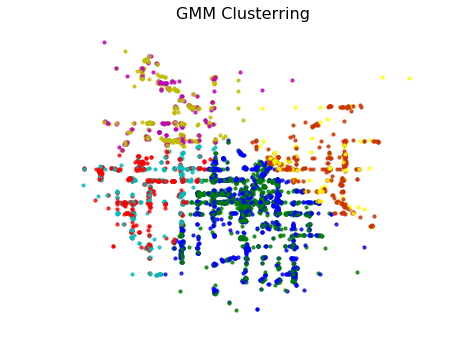

In [792]:
plt.figure(1, figsize=(16,12), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(221)
cluster0Colors = np.array([x for x in 'bg'])
cluster1Colors = np.array([x for x in 'rc'])
cluster2Colors = np.array([x for x in 'my'])
cluster3Colors = np.array(['#ffff00', '#cc3300'])


j = 0
for i in cluster0:
    plt.scatter(locations[i][0], locations[i][1], color=cluster0Colors[cluster0Labels[j]], s=10, alpha=0.8)
    j = j + 1
    
j = 0
for i in cluster1:
    plt.scatter(locations[i][0], locations[i][1], color=cluster1Colors[cluster1Labels[j]], s=10, alpha=0.8)
    j = j + 1
    
j = 0
for i in cluster2:
    plt.scatter(locations[i][0], locations[i][1], color=cluster2Colors[cluster2Labels[j]], s=10, alpha=0.8)
    j = j + 1

j = 0
for i in cluster3:
    plt.scatter(locations[i][0], locations[i][1], color=cluster3Colors[cluster3Labels[j]], s=10, alpha=0.8)
    j = j + 1
    
plt.title('GMM Clusterring', fontsize=16)
plt.axis('off')

In [793]:
cluster0Restaurants = []
for i in cluster0:
    cluster0Restaurants.append(allRestaurants[i][1])
    
cluster1Restaurants = []
for i in cluster1:
    cluster1Restaurants.append(allRestaurants[i][1])

cluster2Restaurants = []
for i in cluster2:
    cluster2Restaurants.append(allRestaurants[i][1])
    
cluster3Restaurants = []
for i in cluster3:
    cluster3Restaurants.append(allRestaurants[i][1])

In [794]:
def label(clusterList):
    regex = re.compile('[^a-zA-Z]')
    cat = {}
    att = {}
    for (categ, attrib) in clusterList:
        for c in categ:
            c = str(c)
            if cat.get(c) is None:
                cat[c] = 1
            else:
                cat[c] = cat[c] + 1
        for a in attrib:
            a = str(a)
            if att.get(a) is None:
                att[a] = 1
            else:
                att[a] = att[a] + 1
                
    for c in cat:
        modC = c
        modC = regex.sub(' ', modC)
        if ' ' in modC:
            modC = modC[:modC.index(' ')]
        modC = modC.lower()
        cat[c] = cat[c] * categoryTfidf[0][categoryFeatureIndex.index(modC)]
        
    for a in att:
        modA = a
        modA = regex.sub(' ', modA)
        if ' ' in modA:
            modA = modA[:modA.index(' ')]
        modA = modA.lower()
        att[a] = att[a] * attributeTfidf[0][attributeFeatureIndex.index(modA)]
    return (cat, att)

In [795]:
import operator
(cat0, att0) = label(cluster0Restaurants)
(cat1, att1) = label(cluster1Restaurants)
(cat2, att2) = label(cluster2Restaurants)
(cat3, att3) = label(cluster3Restaurants)

def getTop2(cat, att):
    top2Cats = []
    for i in range(0,2):          
        keys = cat.keys()
        maxKey = keys[0]
        for key in keys:
            if cat[maxKey] < cat[key]:
                maxKey = key
        del cat[key]
        top2Cats.append(key)

    top2Atts = []
    for i in range(0,2):
        keys = att.keys()
        maxKey = keys[0]
        for key in keys:
            if att[maxKey] < att[key]:
                maxKey = key
        del att[key]
        top2Atts.append(key)
    return (top2Cats, top2Atts)

(top2Cats0, top2Atts0) = getTop2(cat0, att0)
(top2Cats1, top2Atts1) = getTop2(cat1, att1)
(top2Cats2, top2Atts2) = getTop2(cat2, att2)
(top2Cats3, top2Atts3) = getTop2(cat3, att3)

In [796]:
print (top2Cats0, top2Atts0)
print (top2Cats1, top2Atts1)
print (top2Cats2, top2Atts2)
print (top2Cats3, top2Atts3)

(['Soul Food', 'Festivals'], ['Good For Groups', 'Music'])
(['Soul Food', 'Festivals'], ['Good For Groups', 'Music'])
(['Soul Food', 'Tex-Mex'], ['Good For Groups', 'Has TV'])
(['Soul Food', 'Spanish'], ['Good For Groups', 'Has TV'])


For the GMM Clustering I used the same number of clusters as used for K-means++ like you said I could. It looks like the same graph was made but the clusters were just colored differently, leading me to further believe that these categories/attributes are just the leading values for the Las Vegas Restaurants. 

ERROR! Session/line number was not unique in database. History logging moved to new session 131


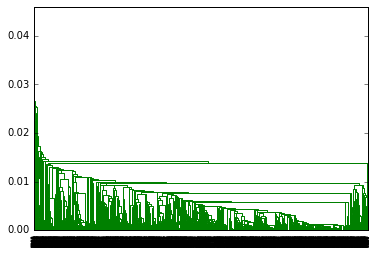

In [807]:
import scipy.cluster.hierarchy as hi
hierarchy = hi.linkage(locations)
dicts = hi.dendrogram(hierarchy)

I have no idea what this dendrogram means and it is also only clustered on locations because I couldn't figure out how to cocluster with hierarchy. If i had more time I would merge my datasets, locations and score, and then make the dendrogram on that to see what it looks like.

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Couldn't figure it out/not enough time because I'm a slacker. Sorry!

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

Hierarchial seems to be the worst for performing co-cluster operations. The tree is also hard to see on small and close values as seen by the graph above. Hierarchial would be more useful for a single cluster on data spread but somehow related. Hierarchial seems to be the hardest to work with, at least through the scipy library. The return from the call to dendrogram is not useful, or easily useful, unlike the other algorithms which were easy to understand.

K-means++ and GMM both performed similarily. GMM has the added benefit that you can decide a shape to look for but that ended up not being useful in our case. Both also worked well with a small number of clusters and were accurate and easy to visualize. While I'm not sure about how the normalization of category/attributes worked, I think the outputs above are correct and that restaurant data in Las Vegas just naturally skews towards what is listed above all over, no matter the cluster on location. 

-----------------

In [805]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../custom.css", "r").read()
    return HTML(styles)
css_styling()